## Background

In the fastai course Part 1 [Lesson 6 video](https://youtu.be/AdhG64NF76E?feature=shared&t=3117) Jeremy Howard walked through the notebooks [First Steps: Road to the Top, Part 1](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) and [Small models: Road to the Top, Part 2](https://www.kaggle.com/code/jhoward/small-models-road-to-the-top-part-2) where he builds increasingly accurate solutions to the [Paddy Doctor: Paddy Disease Classification](https://www.kaggle.com/competitions/paddy-disease-classification) Kaggle Competition. In the video, Jeremy referenced a series of walkthrough videos that he made while working through the four-notebook series for this competition. I'm excited to watch these walkthroughs to better understand how to approach a Kaggle competition from the perspective of a former #1 Kaggle grandmaster.

In this blog post series, I'll walk through the code Jeremy shared in each of the 6 Live Coding videos focused on this competition, submitting predictions to Kaggle along the way. My last two blog posts in this series reference Jeremy's [Scaling Up: Road to the Top, Part 3](https://www.kaggle.com/code/jhoward/scaling-up-road-to-the-top-part-3) notebook to improve my large model ensemble predictions. Here are the links to each of the blog posts in this series:

- [Part 1: Live Coding 8](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-1/)
- Part 2: Live Coding 9 (You are here)
- [Part 3: Live Coding 10](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-3/)
- [Part 4: Live Coding 11](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-4/)
- [Part 5: Live Coding 12](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-5/)
- [Part 6: Live Coding 13](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-6/)
- [Part 7: Improving My Large Ensemble, Part 1](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-7/)
- [Part 8: Improving My Large Ensemble, Part 2](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-8/)


[Link to the Live Coding 9 video](https://www.youtube.com/watch?v=EK5wJRzffas)

## Setup

In [1]:
!pip install -qq timm==0.6.13
import timm
timm.__version__

'0.6.13'

In [2]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *
from fastai.vision.all import *

comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
path.ls()

(#4) [Path('../input/paddy-disease-classification/sample_submission.csv'),Path('../input/paddy-disease-classification/train_images'),Path('../input/paddy-disease-classification/train.csv'),Path('../input/paddy-disease-classification/test_images')]

In [4]:
trn_path = path/'train_images'

## Miscellaneous topics

These are interesting topics Jeremy walked through before going into the Paddy competition stuff.

To keep installed libraries persistent in Paperspace, install them with the `--user` flag.

- Edit `/storage/.bash.local`
- Add to it: `alias pi="pip install -U --user"`
- In bash `type pi` will display what `pi` is aliased as
- `which pi` won't tell you anything useful because `pi` is not a binary
- Run `pi timm`. The `--user` flag will put in the `.local` directory
- Need to make sure that your `.local` directory is symlinked
- This way, you don't have to restart your kernel after `pip install`

Vim commands:

- `/` searches (`/init` will search for the next thing called "init" in the file)
- To go back to where we were: `Ctrl+o`
- To go forward to where you were: `Ctrl+i`
- If you type `f` it will search on the line the next thing you type, `Shift+F` searches backwards
- `Shift+A` to start inserting at the end of the line
- Delete everything up to the next double quote: `d+f+"`
- Press `.` to repeat the previous command
- `%` goes to the next parenthesis (goes to closing parenthesis first)
- Replace all parameters in functions: `c` (for change) + `i` (inside parenthesis) + type the change (like `a,b`) then go down to the next spot and type `.`

## Improving a model for a kaggle competition

Let's now try to improve the model from the first walkthrough.

If you train past 10 epochs, you are in danger of overfitting as your model has seen each image 10 times. In order to avoid overfitting we should make it so that it sees a slightly different image each time. You can pass in `batch_tfms` which will be applied to each mini-batch.

What does `aug_transforms` do? Flip, zoom, adjust brightness for, rotated, warp images. This is called data augmentation. It returns a list of transformations.

In [5]:
aug_transforms(size=224, min_scale=0.75)

[Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ,
 RandomResizedCropGPU -- {'size': (224, 224), 'min_scale': 0.75, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'max_scale': 1.0, 'mode_mask': 'nearest', 'p': 1.0}:
 encodes: (TensorImage,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (TensorMask,object) -> encodes
 decodes: ]

Most models trained on ImageNet are trained on image sizes of 224x224.

In [6]:
dls = ImageDataLoaders.from_folder(
    trn_path, 
    valid_pct=0.2,
    item_tfms=Resize(460, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In `show_batch` if you say `unique=True` it will show the same picture with the different transformations (sometimes it's flipped, sometimes it's moved a little bit up and down, sometimes it's a little bit darker or brighter, or rotated).

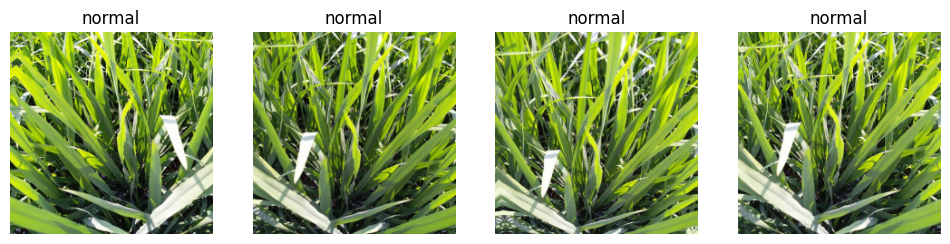

In [7]:
dls.train.show_batch(max_n=4, nrows=1, unique=True)

The default learning rate from fastai is on the conservative side, meaning it's a little bit lower than you probably need because Jeremy wanted things to always be able to train. There's a couple of downsides to using a lower learning rate than you need:

- Given fixed resources and fixed amount of time, you're going to have less distance that the weights can move
- A high learning rate helps the optimizer to explore the space of options by jumping further to see if there's better places to go

In [8]:
learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate).to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


[This forum post](https://forums.fast.ai/t/getting-error-on-kaggle-kernel-when-using-cnn-learner-function/74934/5) (sign-in required) helped resolve the `[Errno 30] Read-only file system: ` error thrown when calling `lr_find`, by changing the `model_dir` attribute of the `Learner`:

In [9]:
learn.model_dir = "/kaggle/working"

SuggestedLRs(valley=0.0008317637839354575, slide=0.004365158267319202)

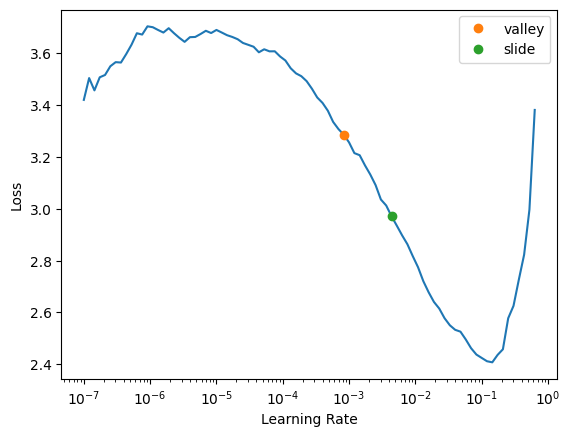

In [10]:
learn.lr_find(suggest_funcs=(valley, slide))

The suggested learning rate is 0.002, but you can see that all the way up to 10^-2 it has a pretty nice slope. We are using 1cycle training schedule which means we are gradually increasing the learning rate and by doing that we can reach higher learning rates, so even these recommendations are going to be on the conservative side. 

In [11]:
learn.fine_tune(12, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.026152,0.743547,0.227775,01:21


epoch,train_loss,valid_loss,error_rate,time
0,0.495129,0.281290,0.087938,01:34
1,0.354283,0.253887,0.085055,01:35
2,0.334391,0.299357,0.084575,01:30
3,0.267883,0.188827,0.052859,01:29
4,0.231655,0.188384,0.052379,01:29
5,0.167554,0.158490,0.043248,01:29
6,0.117927,0.157844,0.039404,01:29
7,0.091830,0.144641,0.033638,01:29
8,0.067092,0.108346,0.027391,01:29
9,0.044437,0.108044,0.025949,01:29


## Saving a trained model

`Learner.export` exports the `Learner` to `Learner.path/fname`. You specify an absolute path with a preceding `'/'`. The `Learner`, in addition to the model and optimizer, contains information about the `DataLoaders` and what transformations were applied.

`Learner.save` exports just the model and optimizer, not the `Learner`.

In [ ]:
learn.path = Path("/kaggle/working")

In [ ]:
learn.export('cn_sml_12.pkl')

## Test Time Augmentation

If you don't use the `'squish'` item transform, the validation set will only use the cropped center portion of the image, and this is a particularly important situation when you should use test time augmentation.

In test time augmentation, we get multiple versions of each image (4 by default) plus the un-augmented version, we get the prediction on every one and then we get the average (or max) prediction. 

We should be able to replicate the final epoch's error rate manually:

In [12]:
probs,targs = learn.get_preds(dl=dls.valid)

In [13]:
error_rate(probs, targs)

TensorBase(0.0250)

Good. That is the same error rate as the final epoch during training. Now let's try out `tta` using the average prediction (of the 4 augemented and 1 un-augmented predictions). We would likely much more clearly see the benefit of `tta` if we did not `squish` the images when creating the `DataLoaders`.



In [14]:
probs,targs = learn.tta(dl=dls.valid)
error_rate(probs,targs)

TensorBase(0.0216)

The average `tta` prediction error rate is less than the regular prediction error rate. Let's see what error rate we get if we use the maximum `tta` predictions:

In [15]:
probs,targs = learn.tta(dl=dls.valid, use_max=True)
error_rate(probs,targs)

TensorBase(0.0235)

In this case, using the max predictions results in a worse error rate. Generally speaking, Jeremy has found then when you are not using `squish`, `use_max=True` results in more accurate predictions.

## Prepare file for kaggle submission

In [16]:
tst_files = get_image_files(path/'test_images').sorted()

In [17]:
tst_dl = dls.test_dl(tst_files)

In [18]:
probs,targs = learn.tta(dl=tst_dl)

Each row of `probs` will contain a probability for each element of the `vocab`. There are 10 probabilities for each of the 3469 images in the test set.

In [19]:
len(dls.vocab), len(tst_dl.dataset)

(10, 3469)

In [20]:
probs.shape

torch.Size([3469, 10])

What is actually predicting? The thing is predicting is whatever thing that has the highest probability. Go through each row and find the index of the thing with the highest probability (`argmax`).

In [21]:
idxs = probs.argmax(dim=1)
idxs.shape

torch.Size([3469])

In [22]:
idxs = pd.Series(idxs.numpy(), name='idxs')

We can rewrite how we create `mapping` by passing it directly the `enumarate` object.

In [23]:
mapping = dict(enumerate(dls.vocab))
results = idxs.map(mapping)
ss = pd.read_csv(path/'sample_submission.csv')
ss['label'] = results

In [24]:
ss.to_csv('subm.csv', index=False)

In [25]:
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


Given that this is an image classification task for natural photos, it will almost certainly have exactly the same characteristics as ImageNet in terms of fine-tuning, so work on the assumption that the things that are in the timm model comparison notebook will apply to this dataset. Once everything is working well, try it on a couple of models or at least run it on a bigger one.

If it was like a segmentation problem or an object detection problem, medical imaging dataset which has pictures that aren't in ImageNet, Jeremy would try more different architectures, but in those cases he would not try to replicate the research of others and would look at paperswithcode.com to find out which techniques have the best results on segmentation and better still would go and find 2-3 previous Kaggle competitions that have a similar problem type and see who won and see what they did. They'll likely have done an ensemble, which is fine, but they will also say "the best model in the ensemble was X", and so just use the smallest version of X I can get away with.

Generally fiddling with architectures tends not to be very useful for any kind of problem that people have fairly regularly studied. 

In my [next blog post](https://vishalbakshi.github.io/blog/posts/2024-02-05-paddy-part-3/) I walk through the discussion and code from Live Coding 10.